In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [3]:
np.random.seed(42)
#from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import autokeras as ak

from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization



In [6]:
skin_df = pd.read_csv('/home/yassine/Desktop/Study/Deep Learning/Classification-of-Dermatoscopic-Images/data/HAM10000/HAM10000_metadata.csv')


SIZE=32

In [7]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

/tmp/ipykernel_34038/3797679965.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


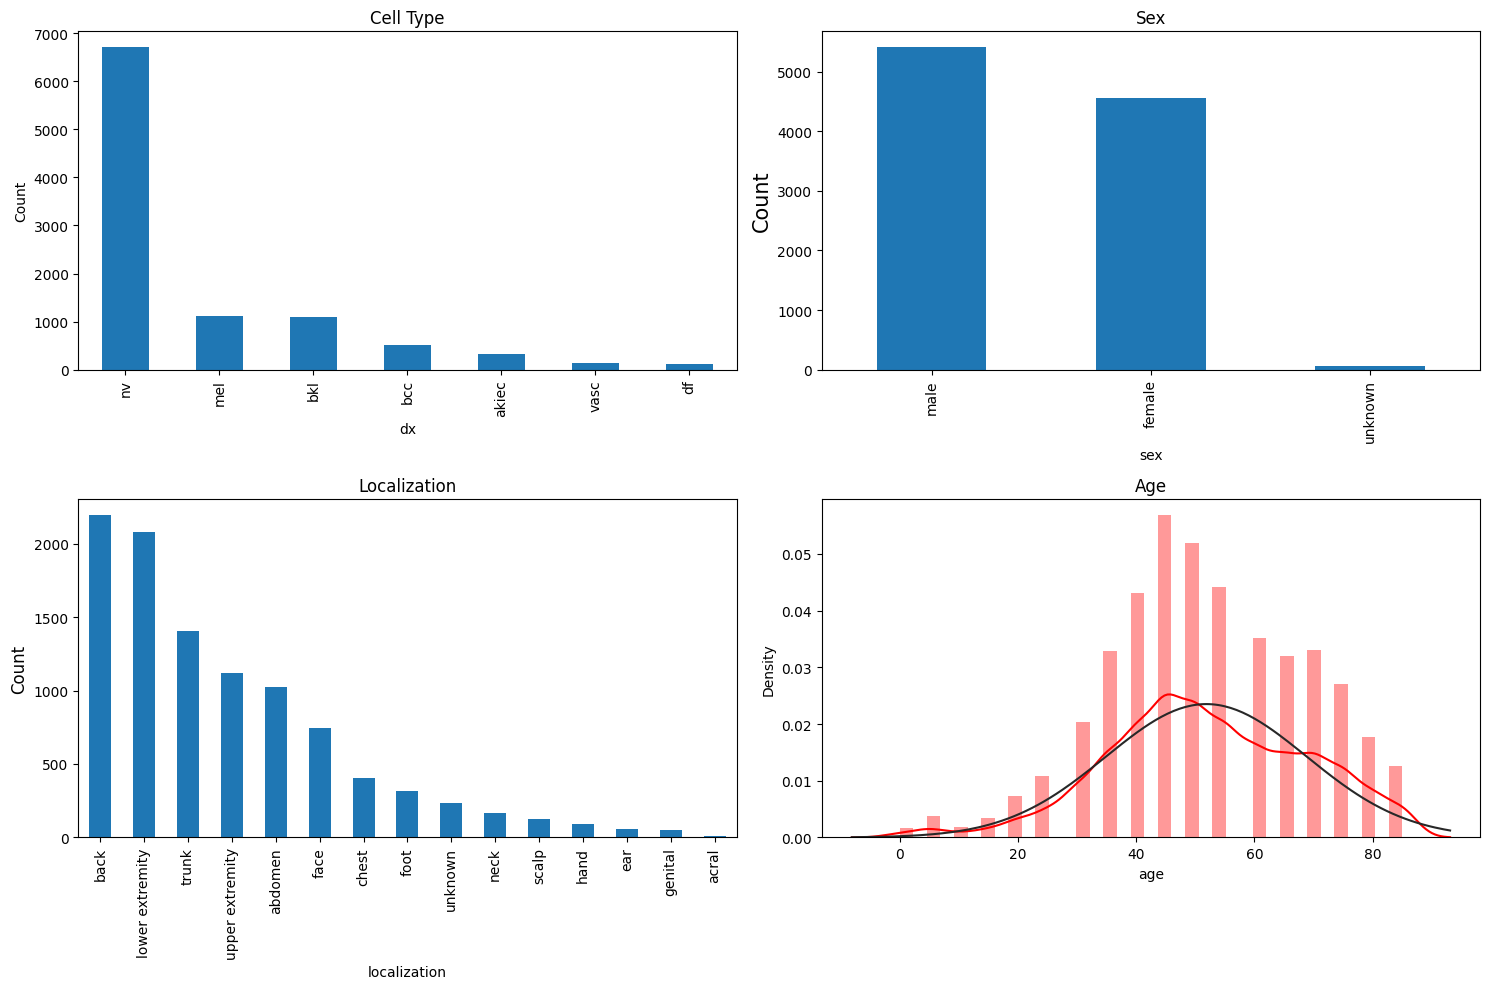

In [8]:

# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()



In [9]:

# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64
label
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: count, dtype: int64


In [11]:

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/home/yassine/Desktop/Study/Deep Learning/Classification-of-Dermatoscopic-Images/data/HAM10000', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  


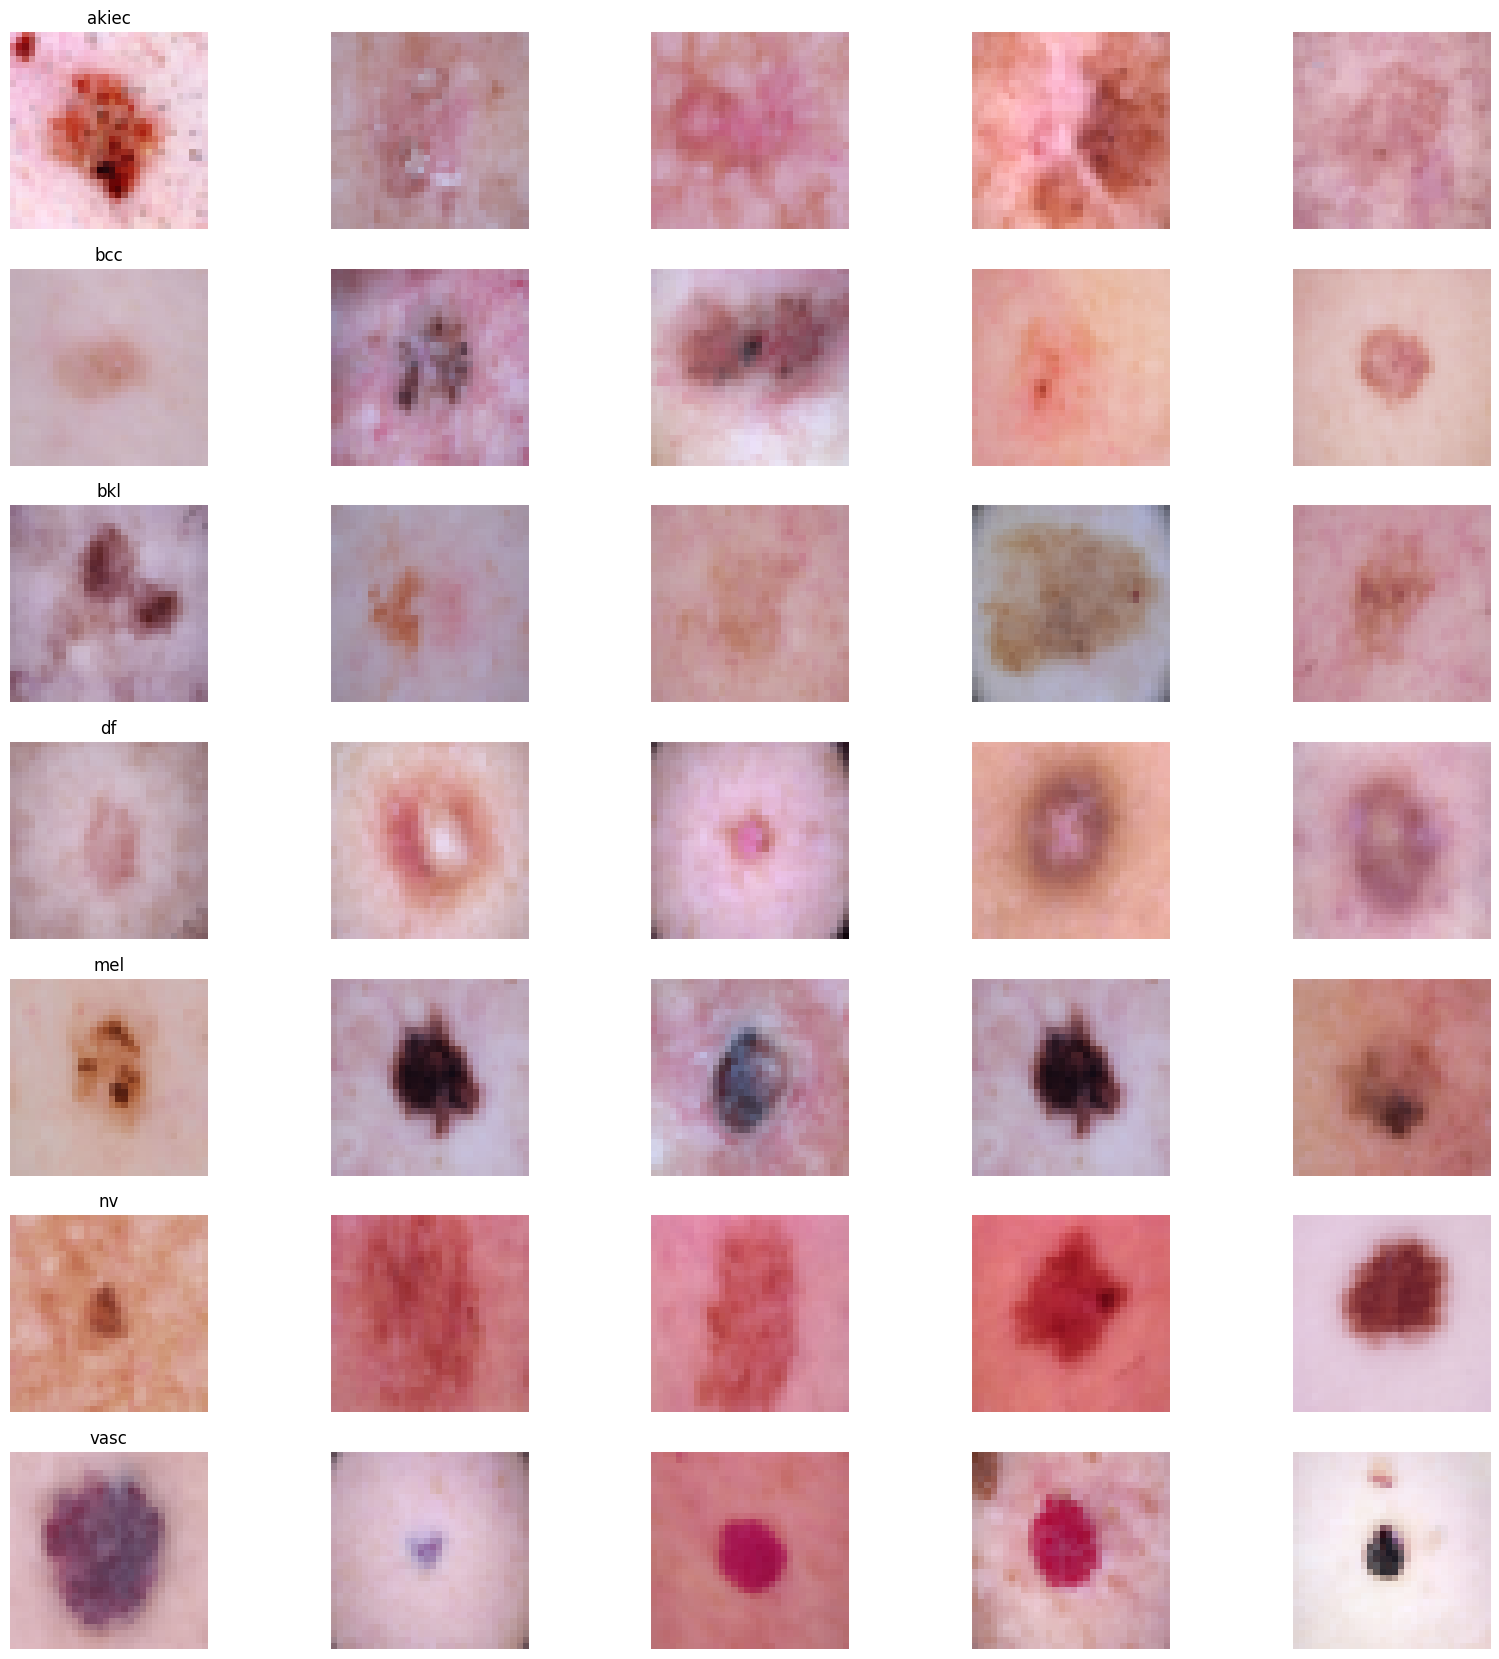

In [12]:

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [13]:

# #Convert dataframe column of images into numpy array
# X = np.asarray(skin_df_balanced['image'].tolist())
# X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
# Y=skin_df_balanced['label'] #Assign label values to Y
# Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
# #Split to training and testing. Get a very small dataset for training as we will be 
# # fitting it to many potential models. 
# x_train, x_train, x_train, x_train = train_test_split(X, Y_cat, test_size=0.95, random_state=42)

# #Further split data into smaller size to get a small test dataset. 
# x_unused, x_valid, y_unused, y_valid = train_test_split(x_train, x_train, test_size=0.05, random_state=42)

# #Define classifier for autokeras. Here we check 25 different models, each model 25 epochs
# clf = ak.ImageClassifier(max_trials=25) #MaxTrials - max. number of keras models to try
# clf.fit(x_train, x_train, epochs=25)



In [14]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)



In [15]:
num_classes = 7
model = tf.keras.Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])




/home/yassine/Desktop/Study/Deep Learning/Classification-of-Dermatoscopic-Images/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,455 (1.47 MB)

 Trainable params: 384,455 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 80

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/80
165/165 - 11s - 65ms/step - acc: 0.1874 - loss: 1.9152 - val_acc: 0.2583 - val_loss: 1.7850
Epoch 2/80
165/165 - 10s - 60ms/step - acc: 0.2983 - loss: 1.6991 - val_acc: 0.3543 - val_loss: 1.5400
Epoch 3/80
165/165 - 9s - 54ms/step - acc: 0.3688 - loss: 1.5278 - val_acc: 0.3269 - val_loss: 1.6261
Epoch 4/80
165/165 - 9s - 52ms/step - acc: 0.4160 - loss: 1.4417 - val_acc: 0.4263 - val_loss: 1.4325
Epoch 5/80
165/165 - 9s - 52ms/step - acc: 0.4560 - loss: 1.4029 - val_acc: 0.4320 - val_loss: 1.3895
Epoch 6/80
165/165 - 9s - 52ms/step - acc: 0.4827 - loss: 1.3341 - val_acc: 0.4297 - val_loss: 1.4384
Epoch 7/80
165/165 - 8s - 51ms/step - acc: 0.4819 - loss: 1.3054 - val_acc: 0.4434 - val_loss: 1.4019
Epoch 8/80
165/165 - 9s - 52ms/step - acc: 0.5006 - loss: 1.2730 - val_acc: 0.5166 - val_loss: 1.2290
Epoch 9/80
165/165 - 8s - 51ms/step - acc: 0.5097 - loss: 1.2440 - val_acc: 0.3017 - val_loss: 1.7019
Epoch 10/80
165/165 - 10s - 62ms/step - acc: 0.4891 - loss: 1.2718 - val_acc: 0.

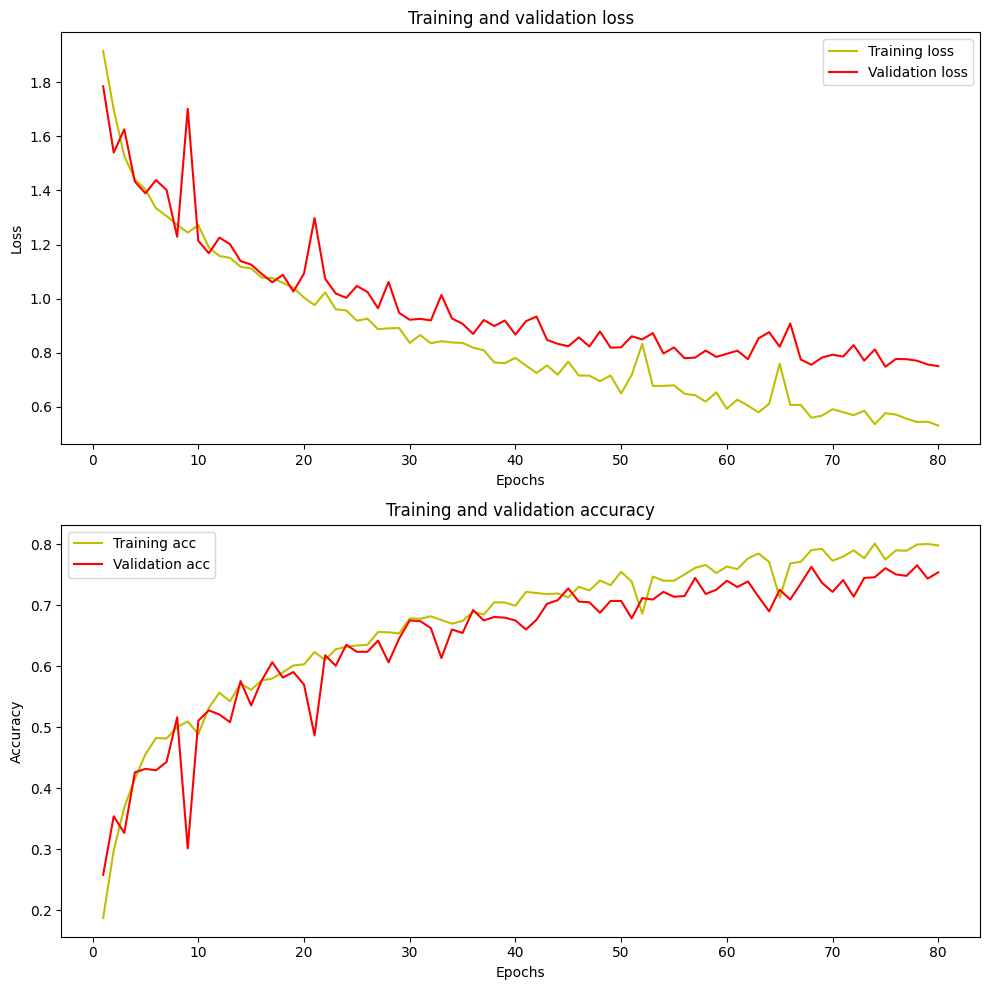

In [17]:
#plot the training and validation accuracy and loss at each epoch
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()



acc = history.history['acc']
val_acc = history.history['val_acc']
ax2.plot(epochs, acc, 'y', label='Training acc')
ax2.plot(epochs, val_acc, 'r', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


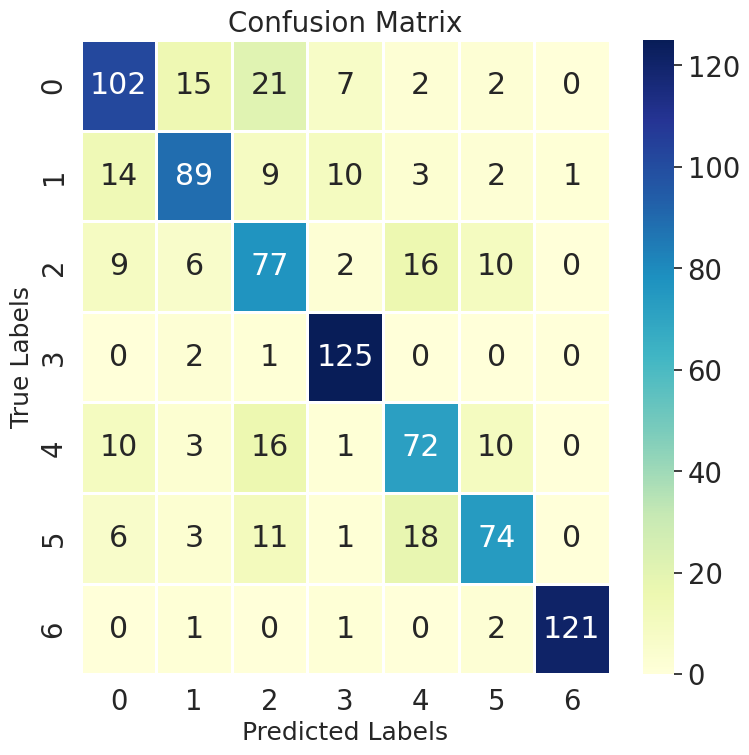

In [19]:
# #Print confusion matrix
# Assuming cm, y_true, and y_pred_classes are already defined
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(8, 8))
sns.set(font_scale=1.8)
sns.heatmap(cm, annot=True, fmt='d', linewidths=1, ax=ax, cmap="YlGnBu")
plt.xlabel('Predicted Labels', fontsize=18)
plt.ylabel('True Labels', fontsize=18)
plt.title('Confusion Matrix', fontsize=20)
plt.tight_layout()
plt.show()



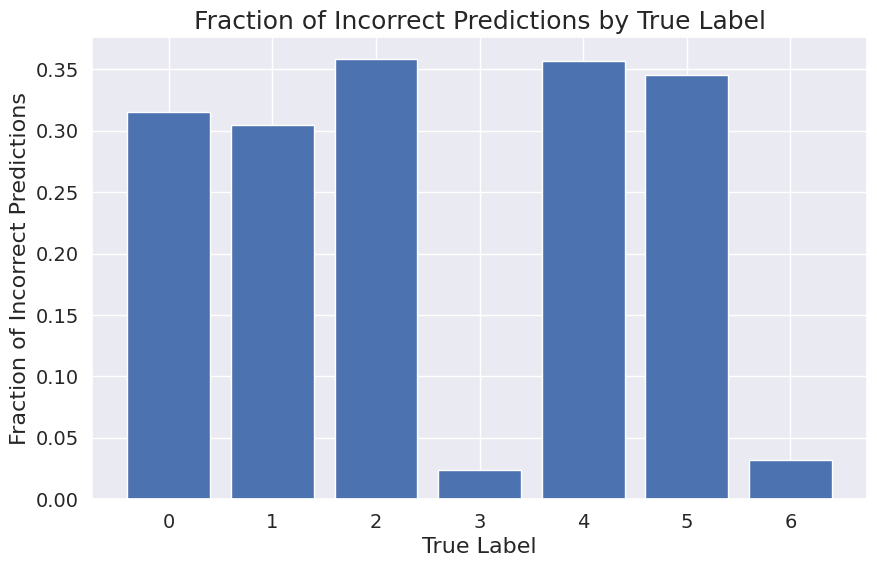

In [20]:

# Plot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

# Create a larger figure
plt.figure(figsize=(10, 6))

# Increase the font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Create a bar chart with labels and titles
plt.bar(np.arange(7), incorr_fraction, tick_label=np.arange(7))
plt.xlabel('True Label', fontsize=16)
plt.ylabel('Fraction of Incorrect Predictions', fontsize=16)
plt.title('Fraction of Incorrect Predictions by True Label', fontsize=18)

# Show the plot
plt.show()